In [3]:
# Leitura do CSV
import pandas as pd
import numpy as np

In [4]:
artists = pd.read_csv('artists.csv')
data_by_artist = pd.read_csv('data_by_artist_o.csv')
data_by_genres = pd.read_csv('data_by_genres_o.csv')
data_by_year = pd.read_csv('data_by_year_o.csv')
data = pd.read_csv('data_o.csv')
tracks = pd.read_csv('tracks.csv')

Como fazer uma predição do gênero de uma música através de seus atributos?

* Porque os gêneros são atributos dos artistas, vamos, primeiramente, construir a relação dos artistas com os gêneros e, depois, dos gêneros com as músicas.
* Desse modo, eliminamos as músicas dos artistas que não possuem gêneros associados a eles. Dito isso, o primeiro passo é eliminar os artistas que não possuem gêneros.



In [5]:
# Getting artist that have genres
artists_with_genres = artists.copy()
artists_with_genres["has_genre"] = artists_with_genres["genres"] != "[]"
artists_with_genres.drop(artists_with_genres[artists_with_genres['has_genre'] == False].index, inplace=True)
# Getting artist that have less than 10 genres
artists_with_genres["genres_list"] = artists_with_genres["genres"].apply(eval)
artists_with_genres["multiple_genres"] = [True if (len(x) > 10) else False for x in artists_with_genres["genres_list"]]
artists_with_genres.drop(artists_with_genres[artists_with_genres['multiple_genres'] == True].index, inplace=True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("'", "")
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("[", "", regex = True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("]", "", regex = True)
artists_with_genres.head()

,id,followers,genres,name,popularity,has_genre,genres_list,multiple_genres
45,0VLMVnVbJyJ4oyZs2L3Yl2,71.0,carnaval cadiz,Las Viudas De Los Bisabuelos,6,True,[carnaval cadiz],False
46,0dt23bs4w8zx154C5xdVyl,63.0,carnaval cadiz,Los De Capuchinos,5,True,[carnaval cadiz],False
47,0pGhoB99qpEJEsBQxgaskQ,64.0,carnaval cadiz,Los “Pofesionales”,7,True,[carnaval cadiz],False
48,3HDrX2OtSuXLW5dLR85uN3,53.0,carnaval cadiz,Los Que No Paran De Rajar,6,True,[carnaval cadiz],False
136,22mLrN5fkppmuUPsHx6i2G,59.0,"classical harp, harp",Vera Dulova,3,True,"[classical harp, harp]",False


* O próximo passo será descobrir quais são os gêneros mais populares. Para isso, vamos contar quantos artistas existem para cada gênero.
* Antes de escolher os gêneros mais populares, temos que agregar os gêneros que são "subgêneros" aos principais. Por exemplo, "alternative rock" é um subgênero de "rock".
* Com essa agregação feita, vamos escolher os 10 gêneros com mais artistas.


In [6]:
genres_dict = {}
for index, artist in artists_with_genres.iterrows():
  for genre in artist['genres_list']:
    if genre in genres_dict:
      genres_dict[genre]+=1
    else:
      genres_dict[genre]=1
genres_dict = sorted(genres_dict.items(), key= lambda x:x[1], reverse=True)
print(genres_dict)

[('pop', 558), ('dance pop', 554), ('electro house', 544), ('classical performance', 502), ('latin', 498), ('hip hop', 470), ('rock', 462), ('pop rap', 454), ('french hip hop', 452), ('rap', 447), ('latin rock', 446), ('edm', 444), ('calming instrumental', 440), ('electropop', 428), ('lo-fi beats', 423), ('indie rock', 419), ('pop edm', 419), ('post-teen pop', 415), ('modern rock', 408), ('german hip hop', 406), ('modern alternative rock', 406), ('k-pop', 406), ('tropical', 405), ('pop rock', 401), ('underground hip hop', 400), ('indie folk', 396), ('indie poptimism', 391), ('europop', 385), ('filmi', 381), ('urban contemporary', 377), ('funk', 376), ('pop dance', 369), ('background music', 368), ('indian classical', 367), ('country rock', 365), ('alternative r&b', 365), ('tropical house', 364), ('stomp and holler', 363), ('corrido', 363), ('trap', 361), ('rock en espanol', 360), ('german pop', 358), ('otacore', 358), ('german rock', 357), ('escape room', 357), ('regional mexican', 353

In [7]:
main_genres = {
  'classical':'orchestra[\s\S]*|\b?[\s\S]*classical[\s\S]*\b?|[\s\S]*piano[\s\S]+|opera',
  'rock':r'[\s\S]+rock[\s\S]*|[\s\S]+metal[\s\S]*|[\s\S]+punk[\s\S]*',
  'pop':r'[\s\S]+pop[\s\S]*',
  'rap':r'[\s\S]* rap[\s\S]*',
  'jazz':r'[\s\S]*jazz[\s\S]*|bossa nova',
  'reggae':r'\b[\s\S]*reggae|latin[\s\S]*',
  'folk':r"[\s\S]*folk[\s\S]*|\brebetiko|hawaiian, jawaiian|ukulele|duranguense|grupera|ranchera|[\s\S]*regional mexican|norteno",
  'country':r'[\s\S]*country[\s\S]*|\btejano\b',
  'rnb':r'[\s\S]*blues[\s\S]*|[\s\S]*r&b[\s\S]*',
  'funk':r'[\s\S]*funk[\s\S]*|[\s\S]*disco[\s\S]*|[\s\S]*hip hop[\s\S]*',
  'edm':r'electronica|[\s\S]*edm[\s\S]*|electro house|electronic trap'
}

for genre in main_genres:
  if genre == 'classical':
    artists_with_genres["genres_main"]=artists_with_genres["genres"].str.replace(main_genres[genre],genre, regex = True)
  else:
    artists_with_genres["genres_main"]=artists_with_genres["genres_main"].str.replace(main_genres[genre],genre, regex = True)

pd.set_option("display.max_rows",None)
artists_with_genres["genres_main"].value_counts().head(11)

rock         47732
pop          36476
funk         14370
classical     9901
folk          9429
jazz          9078
rap           6907
rnb           3679
reggae        2602
country       1846
edm           1474
Name: genres_main, dtype: int64

In [8]:
# Creating a dictionary which categorises an artist's work into a main genre of music

artist_dictionary={}
for index, row in artists_with_genres.iterrows():
    artist_id=row["id"]
    artist_genre=row["genres_main"]
    artist_dictionary[artist_id]=artist_genre

* Com os gêneros setados aos artistas, chegou a hora de adicioná-los nas músicas



In [9]:
tracks_with_genres = tracks.copy()
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [10]:
#Adding a genre column in data2 by using information in dictionary created above
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\[","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\]","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace(", ",",")
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.split(",")

def genre_according_artist(column):
    music_style=[]
    for artist in column:
        artist=artist.strip("'")
        if artist in artist_dictionary:
            #print(artist)
            music_style.append(artist_dictionary[artist])
    return music_style
            
tracks_with_genres["genre"] = tracks_with_genres["id_artists"].apply(genre_according_artist)
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"[tango, vintage tango]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"[tango, vintage tango]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"[adult standards, big band, easy listening, lo..."


* O próximo passo é limpar para os 11 gêneros de interesse
* Temos, entretanto, um problema. Vamos escolher a música 'Leave The Door Open', de Bruno Mars e Anderson .Paak. Essa música é usada para exemplificar o problema: quando temos uma música de dois artistas que produzem diferentes estilos musicais.
* Para solucionar a questão, vamos limpar as músicas que são feitas em parceiras e, a partir daí, filtrar para os gêneros de interesse. Além disso, também vamos retirar as músicas que os artistas não apresentaram um gênero, como feito no tratamento anterior.


In [11]:
track_example = tracks_with_genres.query("'Leave The Door Open' == name")
print(track_example[["artists",'genre']])

                                              artists               genre
93805  ['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']  [pop, escape room]
93949  ['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']  [pop, escape room]


In [12]:
tracks_with_genres["has_genre"] = [x != [] for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['has_genre'] == False].index, inplace=True)

tracks_with_genres["genres_list"] = [len(x) > 1 for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['genres_list'] == True].index, inplace=True)

In [13]:
tracks_with_genres['genre_string'] = [','.join(map(str, l)) for l in tracks_with_genres['genre']]

tracks_with_genres["genre_string"].value_counts().head(11)

rock         145759
pop          132463
jazz          23793
folk          13403
funk          10578
classical      9500
hoerspiel      8424
rap            5732
reggae         3764
country        2987
rnb            2759
Name: genre_string, dtype: int64

In [14]:
training_tracks = tracks_with_genres.query("genre_string in ['classical','rock','pop','rap','jazz','reggae','folk','country','rnb','funk','edm']")
training_tracks.to_csv('training_dataset.csv')
training_tracks.head(11)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,has_genre,genres_list,genre_string
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.614,0.0423,...,0.996,0.002930,0.1830,0.211,89.822,4,[jazz],True,False,jazz
151,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,30,206600,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.537,0.0443,...,0.996,0.000265,0.1520,0.137,80.468,4,[jazz],True,False,jazz
152,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',28,192600,0,['Louis Armstrong'],['19eLuQmk9aCobbVDHc6eek'],1923,0.665,0.2540,...,0.976,0.002170,0.6440,0.503,125.734,4,[jazz],True,False,jazz
153,6XTvSCqGLLH0vzQQRn55hz,"Empty Bed Blues, Pt. 1",27,181173,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.709,0.0620,...,0.995,0.003410,0.1200,0.553,85.854,4,[jazz],True,False,jazz
154,6qRvnXftofjYJm1Mg98UWL,Need a Little Sugar in My Bowl,27,167640,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.693,0.0270,...,0.992,0.000000,0.1340,0.402,75.749,4,[jazz],True,False,jazz
155,0V1iYWPXCBTaB6dhbiprGF,Send Me to the 'Lectric Chair,26,201480,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.771,0.0905,...,0.986,0.000141,0.1520,0.601,87.571,4,[jazz],True,False,jazz
156,6sOKopKyVWwEJKh8zztYp5,Young Woman's Blues,25,187960,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.525,0.2320,...,0.995,0.018100,0.4610,0.411,76.140,4,[jazz],True,False,jazz
157,0rUf1j43orpfi6f4LbVo8D,Careless Love,25,205053,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.587,0.1750,...,0.992,0.000318,0.0730,0.483,98.523,4,[jazz],True,False,jazz
158,1yjck0Owf0HfhY5kWHiXIQ,Me and My Gin,23,169960,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.710,0.0735,...,0.990,0.000000,0.0941,0.494,90.917,4,[jazz],True,False,jazz
159,2ivh0kwd7QIViw6YqDPdBA,Blue Yodel No. 9,23,157373,0,['Jimmie Rodgers'],['0Y0ZlznP6vzTS1qAm5dvTN'],1923,0.760,0.2510,...,0.969,0.000002,0.0561,0.735,108.456,4,[folk],True,False,folk


!!!!!!!!!!! Fim da Preparação dos Dados

* Feita nossa preparação dos dados - que consistiu de filtrar os dados e atribuir gêneros para cada canção baseado nos gêneros dos artistas - passamos a analisar nossos dados.
* Vamos, primeiro, analisar os dados para cada atributo (que se aplica) de forma mais geral. Vamos analisar a média de cada um deles agrupando os gêneros.
* Nosso objetivo será ver se existe algum(ns) atributos que se destacam para diferenciar os gêneros, uma vez que queremos selecionar os atributos que melhor definem um modelo.


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

Para fazermos nossas análises, temos que saber o que representa cada atributo.


---


* Danceability - é medida usando uma mistura de recursos da música, como intensidade da batida, estabilidade do tempo e tempo geral. O valor retornado determina a facilidade com que uma pessoa pode dançar uma música durante toda a música.
* Energy - é quantificada em decibéis, unidade usada para medir a intensidade do som.
* Key - tom é a escala (maior ou menor) em torno da qual uma peça musical gira. Uma música em tom maior é baseada em escala maior. Uma música em tom menor é baseada em uma escala menor.
* Loudness - É completamente subjetivo e baseado inteiramente na percepção pessoal do som. O conteúdo de frequência, duração e volume de um som são fatores que determinam como percebemos seu volume.
* Mode -  É um tipo de escala musical acoplada a um conjunto de comportamentos melódicos e harmônicos característicos.
* Speechiness - Detecta a presença de palavras faladas em uma faixa.
* Acousticness -Uma medida de confiança de 0,0 a 1,0 de se a faixa é acústica. 1.0 representa alta confiança de que a faixa é acústica.
* Instrumentalness - prevê se uma faixa não contém vocais. Quanto mais próximo o valor da instrumentalidade estiver de 1,0, maior será a probabilidade de a faixa não conter conteúdo vocal. Valores acima de 0,5 destinam-se a representar faixas instrumentais, mas a confiança é maior à medida que o valor se aproxima de 1,0.
* Liveness - detecta a presença de um público na gravação. Valores de vivacidade mais altos representam um aumento na probabilidade de a trilha ter sido executada ao vivo. Um valor acima de 0,8 fornece uma forte probabilidade de que a faixa esteja ao vivo.
* Valence - Uma medida de 0,0 a 1,0 que descreve a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórico), enquanto faixas com baixa valência soam mais negativas (por exemplo, triste, deprimido, com raiva).
* Tempo - O tempo estimado geral de uma faixa em batidas por minuto (BPM). Na terminologia musical, o tempo é a velocidade ou ritmo de uma determinada peça e deriva diretamente da duração média do tempo. 
* Duration_ms - duração em milisegundos da canção.
* Time_signature - fórmula de compasso da canção.
* Explicit - se a música possui ou não palavrões.
---


In [16]:
# Normalizando atributos não normalizados
training_tracks["tempo_norm"] = ((training_tracks["tempo"] - training_tracks["tempo"].mean())/training_tracks["tempo"].std(ddof=1))
training_tracks["duration_ms_norm"] = ((training_tracks["duration_ms"] - training_tracks["duration_ms"].mean())/training_tracks["duration_ms"].std(ddof=1))
training_tracks["loudness_norm"] = ((training_tracks["loudness"] - training_tracks["loudness"].mean())/training_tracks["loudness"].std(ddof=1))

C:\Users\Lucas\AppData\Local\Temp/ipykernel_240/2038225441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_tracks["tempo_norm"] = ((training_tracks["tempo"] - training_tracks["tempo"].mean())/training_tracks["tempo"].std(ddof=1))
C:\Users\Lucas\AppData\Local\Temp/ipykernel_240/2038225441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_tracks["duration_ms_norm"] = ((training_tracks["duration_ms"] - training_tracks["duration_ms"].mean())/training_tracks["duration_ms"].std(ddof=1))
C:

In [24]:
def to_plot(df,colum):
    sns.barplot(x=df[colum],ci=None,y ='genre_string',data=df)
    plt.xlabel(colum)

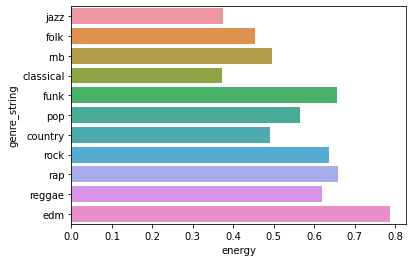

In [25]:
to_plot(training_tracks,"energy")

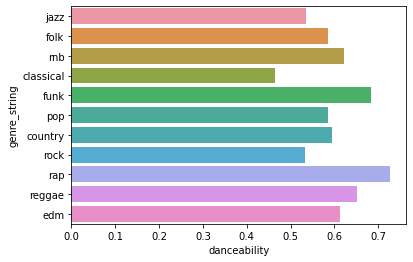

In [26]:
to_plot(training_tracks,"danceability")

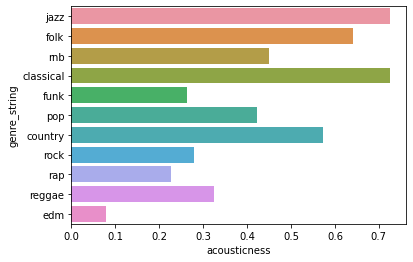

In [27]:
to_plot(training_tracks,"acousticness")

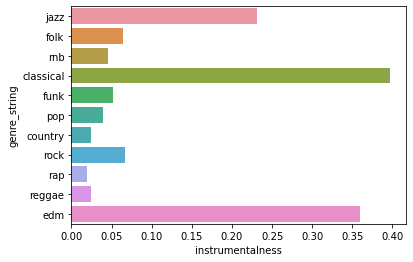

In [28]:
to_plot(training_tracks,"instrumentalness")

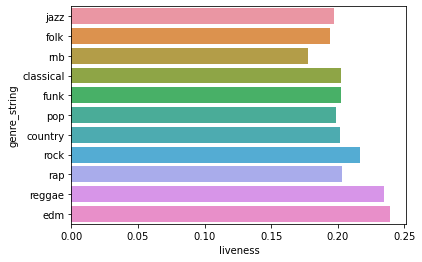

In [29]:
to_plot(training_tracks,"liveness")

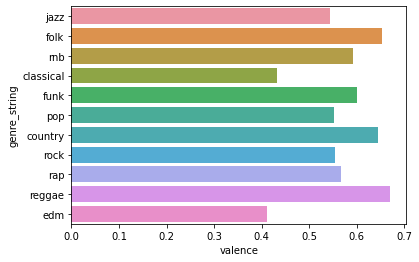

In [30]:
to_plot(training_tracks,"valence")

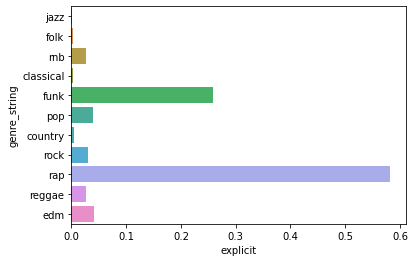

In [31]:
to_plot(training_tracks,"explicit")

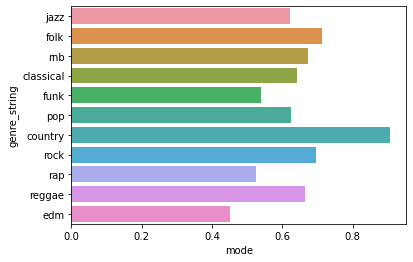

In [32]:
to_plot(training_tracks,"mode")

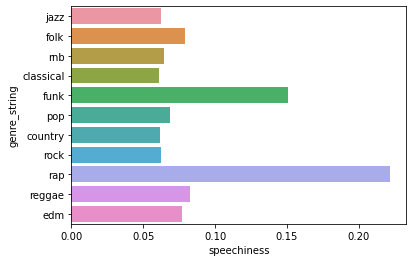

In [33]:
to_plot(training_tracks,"speechiness")

* Como a plotagem da média dos atributos para cada gênero, podemos ver atributos em que os gêneros claramente se diferenciam mais, ou seja, esses atributos seriam mais "definidores" dentro do raciocínio que estamos construindo.

* Entretanto, a média é uma forma muito simples de analizar esses dados de formar a tirar uma informação real.

* Vamos, então, plotar gráficos de dispersão dos dados para dar uma noção mais segura dos dados que temos e, assim, continuar nossa análise.

Teremos de fazer um tratamento dos dados contínuos para apresentá-los. Vamos juntá-los em bins, ou seja, potes de agrupamento. Apesar deste detalhe, teremos uma vantagem ainda maior neste próximo passo: atributos categóricos serão analisados da forma correta, uma vez que a análise dele como média não é boa.